In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import models
from sklearn.metrics import roc_auc_score, classification_report
from torch.utils.data import DataLoader, Dataset, random_split

In [4]:
class LensDataset(Dataset):
    def __init__(self, lens_dir, nonlens_dir, transform=None):
        self.transform = transform
        self.data = []
        self.labels = []

        # Load Lensed Images (Label = 1)
        for file in os.listdir(lens_dir):
            img = np.load(os.path.join(lens_dir, file))
            self.data.append(img)
            self.labels.append(1)

        # Load Non-Lensed Images (Label = 0)
        for file in os.listdir(nonlens_dir):
            img = np.load(os.path.join(nonlens_dir, file))
            self.data.append(img)
            self.labels.append(0)

        # Convert to NumPy array
        self.data = np.array(self.data)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]

        # Convert to tensor
        img = torch.tensor(img, dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, label


In [5]:
# Define dataset paths
data_root = "C:\\Users\\DTSC302\\Desktop\\Anannya\\gsoc\\lens-finding-test"
train_lens_dir = os.path.join(data_root, "train_lenses")
train_nonlens_dir = os.path.join(data_root, "train_nonlenses")
test_lens_dir = os.path.join(data_root, "test_lenses")
test_nonlens_dir = os.path.join(data_root, "test_nonlenses")

# Load datasets
dataset = LensDataset(train_lens_dir, train_nonlens_dir)
test_dataset = LensDataset(test_lens_dir, test_nonlens_dir)

# Split into Train (90%) and Validation (10%)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")


Train samples: 27364, Validation samples: 3041, Test samples: 19650


In [6]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.ToTensor()
])
dataset = LensDataset(train_lens_dir, train_nonlens_dir, transform=transform)


In [7]:
# Define class weights for imbalanced data
class_counts = np.bincount(dataset.labels)
batch_size = 64

from torch.utils.data import SubsetRandomSampler

# Get indices of both classes
lens_indices = [i for i, label in enumerate(dataset.labels) if label == 1]
nonlens_indices = [i for i, label in enumerate(dataset.labels) if label == 0]

# Reduce oversampling ratio (e.g., 1:3 instead of 1:1)
oversampling_ratio = 5

oversampled_lens_indices = np.random.choice(
    lens_indices, size=len(nonlens_indices) // oversampling_ratio, replace=True
)
balanced_indices = np.concatenate([oversampled_lens_indices, nonlens_indices])

# Use SubsetRandomSampler with adjusted oversampling
balanced_sampler = SubsetRandomSampler(balanced_indices)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=balanced_sampler)


In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# Preliminary EDA
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of test samples:", len(test_dataset))

Number of training samples: 27364
Number of validation samples: 3041
Number of test samples: 19650


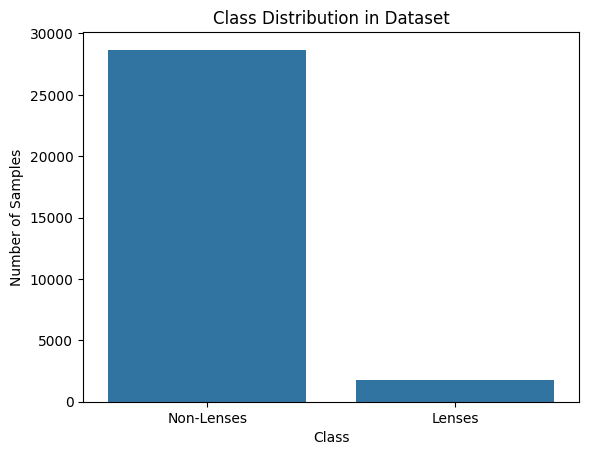

In [10]:
# Visualizing class distribution
sns.barplot(x=['Non-Lenses', 'Lenses'], y=class_counts)
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Dataset")
plt.show()

In [11]:
# Define ResNet-34 Model
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define ResNet-34 Model (Larger than ResNet-18)
class ResNet34Classifier(nn.Module):
    def __init__(self):
        super(ResNet34Classifier, self).__init__()
        self.model = models.resnet34(pretrained=True)  # Upgraded from ResNet-18
        self.model.fc = nn.Linear(self.model.fc.in_features, 2)  # 2 output classes
    
    def forward(self, x):
        return self.model(x)

model = ResNet34Classifier().to(device)

c:\Users\DTSC302\Desktop\Anannya\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DTSC302\Desktop\Anannya\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Define Focal Loss with class weights
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean', label_smoothing=0.05):
        super(FocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha) if alpha is not None else None
        self.gamma = gamma
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none', label_smoothing=self.label_smoothing)(inputs, targets)
        pt = torch.exp(-ce_loss)
        if self.alpha is not None:
            alpha_factor = self.alpha.to(inputs.device)[targets]
        else:
            alpha_factor = 1
        focal_loss = alpha_factor * (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Adjusted Class Weights
num_lensed = 1730
num_nonlensed = 28675
total_samples = num_lensed + num_nonlensed

weight_lensed = total_samples / (2.5 * num_lensed)
weight_nonlensed = total_samples / (2.5 * num_nonlensed)

alpha = [weight_nonlensed, weight_lensed]
criterion = FocalLoss(alpha=alpha, gamma=1, label_smoothing=0.02).to(device)

optimizer = optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
# MixUp Augmentation
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# Modified Training Loop with MixUp
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        images, labels_a, labels_b, lam = mixup_data(images, labels)
        optimizer.zero_grad()
        outputs = model(images)
        loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

In [ ]:
# Validation
model.eval()
val_labels = []
val_preds = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)[:, 1]
        val_preds.extend(probs.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

roc_auc = roc_auc_score(val_labels, val_preds)
print(f"Validation ROC-AUC: {roc_auc:.4f}")

In [ ]:
# Test Classification Report
test_labels = []
test_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(test_labels, test_preds))

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Lensed", "Lensed"], yticklabels=["Non-Lensed", "Lensed"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# ROC Curve
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

val_labels = []
val_probs = []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)[:, 1]
        val_probs.extend(probs.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

fpr, tpr, _ = roc_curve(val_labels, val_probs)
roc_auc = roc_auc_score(val_labels, val_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
# Save model weights
torch.save(model.state_dict(), "attempt11.pth")